In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm

import matplotlib
from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amsfonts}',
    r'\usepackage{amssymb}']
rc('text', usetex=False)

import xarray as xr
import xgcm

import cartopy.crs as ccrs
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='papayawhip', linewidth=0.5)

import matplotlib.path as mpath




In [2]:
# set up a larger cluster
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster





In [3]:
# either way, run this
client = Client()



In [4]:
print(client)

<Client: 'tcp://127.0.0.1:39091' processes=7 threads=14, memory=64.00 GiB>


## Input parameters

In [5]:
# these are the values used by MOM5

Ω = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m


# 0.1° global


In [6]:
# session = cc.database.create_session()
session = cc.database.create_session()#db='/g/data/ik11/databases/cosima_master_2022-07-01.db')

# reference density value:
rho_0 = 1035.0
g = 9.81

# Restrict to Southern Ocean latitudes
lat_range = slice(-80,-35)

In [59]:
# expt = '01deg_jra55v140_iaf_cycle3'
expt = '01deg_jra55v140_iaf_cycle4'

start_time = '1999-01-01'
end_time = '2018-12-31'

time_slice = slice(start_time, end_time)

In [60]:
# laod variables

u = cc.querying.getvar(expt, 'u', session, start_time = start_time, end_time = end_time,)
u = u.sel(time=time_slice).sel(yu_ocean=lat_range)

v = cc.querying.getvar(expt, 'v', session, start_time = start_time, end_time = end_time)
v = v.sel(time=time_slice).sel(yu_ocean=lat_range)

ssh = cc.querying.getvar(expt, 'sea_level', session, start_time = start_time, end_time = end_time, frequency ='1 monthly')
ssh = ssh.sel(time=time_slice).sel(yt_ocean=lat_range)



In [51]:
# depth at temperature points
ht = cc.querying.getvar(expt, 'ht', session, n=1)

# coarsen ht to reduce wiggles and things

ht_coarse = ht.coarsen(xt_ocean=5).mean().coarsen(yt_ocean=5).mean()

In [12]:
xt_ocean = cc.querying.getvar(expt, 'xt_ocean', session, n=1)
yt_ocean = cc.querying.getvar(expt, 'yt_ocean', session, n=1)

st_ocean = cc.querying.getvar(expt,'st_ocean', session, n=-1)
st_edges_ocean= cc.querying.getvar(expt,'st_edges_ocean', session, n=-1)

dstF = xr.DataArray(st_edges_ocean.values[1:] - st_edges_ocean.values[:-1],
                   coords={'st_ocean':st_ocean},
                   dims={'st_ocean':st_ocean})

dxu = cc.querying.getvar(expt, 'dxu', session, n=1)
dyt = cc.querying.getvar(expt, 'dyt', session, n=1)



In [13]:
ds = xr.Dataset({'u':u,'v':v, 'xt_ocean':xt_ocean, 'yt_ocean':yt_ocean, 'st_edges_ocean':st_edges_ocean,
                'dxu':dxu, 'dyt':dyt}) 
grid = xgcm.Grid(ds, coords={'X':{'center':'xt_ocean', 'right':'xu_ocean'},
                             'Y':{'center':'yt_ocean','right':'yu_ocean'},
                             'Z':{'center':'st_ocean', 'outer':'st_edges_ocean'}}, periodic = ['X'])




In [14]:
ζ_xgcm = ( grid.interp( grid.diff(ds.v, 'X') / grid.interp(ds.dxu, 'X'), 'Y', boundary='extend')
          - grid.interp( grid.diff(ds.u, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'X') )

ζ_xgcm = ζ_xgcm.rename('Relative Vorticity')
ζ_xgcm.attrs['long_name'] = 'Relative Vorticity, ∂v/∂x-∂u/∂y'
ζ_xgcm.attrs['units'] = 's-1'

In [24]:
u

,Array,Chunk
Bytes,30.56 GiB,1.76 MiB
Shape,"(36, 75, 844, 3600)","(1, 19, 135, 180)"
Count,196197 Tasks,20160 Chunks
Type,float32,numpy.ndarray


In [61]:
u_surface_mean = u.sel(st_ocean=20, method='nearest').mean(dim='time')

In [62]:
u_surface_mean.load()

<xarray.DataArray 'u' (yu_ocean: 844, xu_ocean: 3600)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.00373749, 0.00458217, 0.00526862, ..., 0.00160333, 0.00192671,
        0.00278008],
       [0.00419436, 0.00478914, 0.00514482, ..., 0.00220067, 0.00249208,
        0.00329859],
       [0.00491481, 0.00537573, 0.00570387, ..., 0.00393228, 0.0041241 ,
        0.00447792]], dtype=float32)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -79.99 -79.95 -79.9 ... -35.24 -35.16 -35.08
    st_ocean  float64 19.15

In [63]:
ssh_mean = ssh.mean(dim='time')

In [55]:
depth_contour_levels = np.array([3])*1e3
depth_contour_levels

array([3000.])

In [48]:
ssh_contour_levels = np.linspace(-2,1, num=7)
ssh_contour_levels

array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ])

CPU times: user 17.7 s, sys: 1.17 s, total: 18.8 s
Wall time: 18.3 s


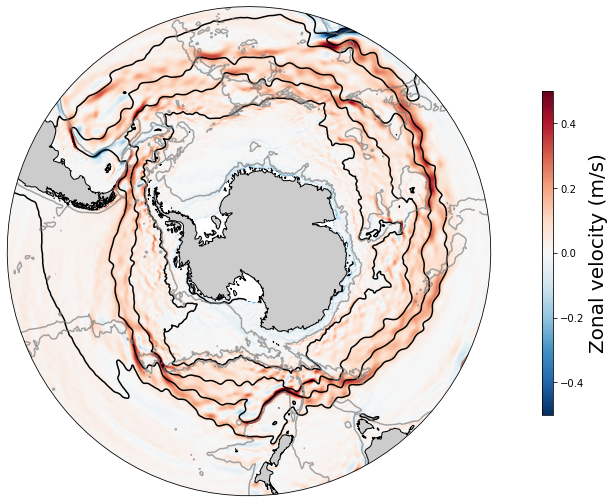

In [66]:
%%time

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(10, 9))
ax = plt.subplot(1, 1, 1, projection=projection)

ax.set_extent([-280, 80, -80, -35], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')


# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

p1 = u_surface_mean.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, vmin=-0.5, vmax=0.5, cmap='RdBu_r')
ax.set_title('')

ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('Zonal velocity (m/s)', fontsize=20);

ssh_mean.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='k', alpha=1, levels=ssh_contour_levels, linestyles='solid')

ht_coarse.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='grey', alpha=0.7, levels=depth_contour_levels, linestyles='solid')



fig.savefig('/g/data/jk72/ed7737/RoG plots/zonal_vel_ssh.png', dpi=200, bbox_inches='tight')